In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers as layers
import keras.backend as K
import keras.utils
import tensorflow as tf

from tqdm import tqdm
import chipwhisperer as cw
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import Dark2_5 as palette
import itertools
import datetime
import time
import h5py

In [2]:
in_file = h5py.File("./ASCAD/"+'ASCAD.h5', "r")
X_profiling = np.array(in_file['Profiling_traces/traces'], dtype=np.int8)
X_attacks = np.array(in_file['Attack_traces/traces'], dtype=np.int8)

X_profiling_metadata = np.array(in_file['Profiling_traces/metadata/'])
X_attack_metadata = np.array(in_file['Attack_traces/metadata/'])

plain = [[] for i in range(50000)]
for idx in range(50000):
    plain[idx] = X_profiling_metadata[idx]['plaintext']
plain = np.array(plain, dtype=np.uint8)

keys = [[] for i in range(50000)]
for idx in range(50000):
    keys[idx] = X_profiling_metadata[idx]['key']
keys = np.array(keys, dtype=np.uint8)

plain_test = [[] for i in range(10000)]
for idx in range(10000):
    plain_test[idx] = X_attack_metadata[idx]['plaintext']
plain_test = np.array(plain_test, dtype=np.uint8)

keys_test = [[] for i in range(10000)]
for idx in range(10000):
    keys_test[idx] = X_attack_metadata[idx]['key']
keys_test = np.array(keys_test, dtype=np.uint8)

X_attack = np.concatenate((X_profiling[:10000], X_attacks), axis = 0)
pt_set = np.concatenate((plain[:10000], plain_test), axis = 0)
ky_set = np.concatenate((keys[:10000], keys_test), axis = 0)

In [3]:
X_attack.shape

(20000, 700)

In [4]:
print(pt_set.shape)
print(ky_set.shape)

(20000, 16)
(20000, 16)


In [5]:
output_notebook()
p = figure(sizing_mode='scale_width', plot_height=200)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(X_attack[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, X_attack[i], color=color)
show(p)

Loading BokehJS ...

In [6]:
# 전처리 파형 중 일부사용
X_attack_normal = np.array(X_attack[:], dtype='float64')
for i in range(len(X_attack)):
    X_attack_normal[i] -= X_attack_normal[i].mean()
    MIN = min(X_attack_normal[i])
    MAX = max(X_attack_normal[i])
    X_attack_normal[i] = ((X_attack_normal[i] - MIN)/(MAX - MIN) - 0.5) * 2
    
output_notebook()
p = figure(sizing_mode='scale_width', plot_height=200)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(X_attack_normal[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, X_attack_normal[i], color=color)
show(p)

Loading BokehJS ...

In [2]:
Sbox = [
0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
]

In [8]:
class Custom(layers.Activation):
    def __init__(self, activation, **kwargs):
        super(Custom, self).__init__(activation, **kwargs)
        self.__name__ = 'Custom'

def custom(x):
    return tf.math.abs(x)

keras.utils.get_custom_objects().update({'Custom': Custom(custom)})

In [9]:
def build_MLP(points_len, hidden_nodes = [300, 300, 300], dropout_layers = [0.2, 0.2, 0.2],
              optimizer = keras.optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)):
    model = keras.models.Sequential()
    model.add(layers.BatchNormalization())
    
    # dense 레이어 추가
    model.add(layers.Dense(hidden_nodes[0], kernel_initializer = 'he_normal', input_dim = points_len, name = 'dense_1'))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    
    if dropout_layers[0] != 0:
        model.add(layers.Dropout(dropout_layers[0], name = 'dropout_1'))

    for i, num_units in enumerate(hidden_nodes[1:]):
        model.add(layers.Dense(num_units, kernel_initializer = 'he_normal', name = 'dense_{}'.format(i + 2)))
        model.add(layers.Activation('relu'))
        model.add(layers.BatchNormalization())
        if dropout_layers[i + 1] != 0:
            model.add(layers.Dropout(dropout_layers[i + 1], name = 'dropout_{}'.format(i + 2)))

    model.add(layers.Dense(1, kernel_initializer = 'he_normal', name = 'output'.format(len(hidden_nodes) + 1)))
    model.add(layers.Activation('sigmoid'))
    
    z = layers.Input(shape = (points_len, ), name = 'input')
    sequence = model(z)

    m = keras.models.Model(z, sequence, name = 'MLSCA')
    m.summary(80)
    
    m.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

    return m

In [3]:
target_byte = 2
All_difference = []

def analysis_MLP(m, Init, traces, pts, tr_num, num_keycandi, result_type, num_epochs, batch_size, right_key):
    right_candi = 0
    right_candida = 0
    accuracies = []
    losses     = []
    
    best_acc = 0
    best_loss = 100
    
    val_right_candi = 0
    val_right_candida = 0
    val_accuracies = []
    val_losses     = []
    
    val_best_acc = 0
    val_best_loss = 100
    
    train_num = int(tr_num * 0.8)
    
    for k in tqdm(range(num_keycandi)):
        m.set_weights(Init)

        hypothesis = np.array(Sbox)[(pts[:, target_byte] ^ k).astype(int)]
        #target = sum([hypothesis & (1 << i) > 0 for i in range(8)])
        #target = keras.utils.to_categorical(target, 9)
        #target = ((hypothesis >> 6) & 1).astype(float)
        target = (hypothesis & 1).astype(float)
        #target = keras.utils.to_categorical(target, 2)
        #target = np.array([(hypothesis & 1).astype(float), ((hypothesis & 2) >> 1).astype(float),((hypothesis & 4) >> 2).astype(float),((hypothesis & 8) >> 3).astype(float),((hypothesis & 16) >> 4).astype(float),((hypothesis & 32) >> 5).astype(float),((hypothesis & 64) >> 6).astype(float),((hypothesis & 128) >> 7).astype(float) ])
        #target = np.transpose(target)
        
        m.fit(x = traces[:train_num], y = target[:train_num], validation_data = (traces[train_num:tr_num], target[train_num:tr_num]), epochs = num_epochs, batch_size = batch_size, verbose = 0)

        accuracies.append(m.history.history['accuracy'])
        if best_acc < m.history.history['accuracy'][num_epochs - 1]:
            best_acc = m.history.history['accuracy'][num_epochs - 1]
            right_candi = k
            
        val_accuracies.append(m.history.history['val_accuracy'])
        if k == 0:
            val_best_acc = m.history.history['val_accuracy'][num_epochs - 1]
            val_right_candi = k
        if val_best_acc < m.history.history['val_accuracy'][num_epochs - 1]:
            val_best_acc = m.history.history['val_accuracy'][num_epochs - 1]
            val_right_candi = k
        
        losses.append(m.history.history['loss'])
        if best_loss > m.history.history['loss'][num_epochs - 1]:
            best_loss = m.history.history['loss'][num_epochs - 1]
            right_candida = k
        
        val_losses.append(m.history.history['val_loss'])
        if k == 0:
            val_best_loss = m.history.history['val_loss'][num_epochs - 1]
            val_right_candida = k
        if val_best_loss > m.history.history['val_loss'][num_epochs - 1]:
            val_best_loss = m.history.history['val_loss'][num_epochs - 1]
            val_right_candida = k
            
    print("Right candidate: ", hex(right_candi))

    plt.figure(figsize = (16, 6))
    for k in range(0, right_candi - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    for k in range(right_candi + 1, num_keycandi - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    plt.plot(accuracies[~right_candi], color = 'black', label = 'wrong key')
    plt.plot(accuracies[right_candi], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    print("Right candidate: ", hex(val_right_candi))

    plt.figure(figsize = (16, 6))
    for k in range(0, val_right_candi - 1):
        plt.plot(val_accuracies[k], color = 'black', label = None)
    for k in range(val_right_candi + 1, num_keycandi - 1):
        plt.plot(val_accuracies[k], color = 'black', label = None)
    plt.plot(val_accuracies[~val_right_candi], color = 'black', label = 'wrong key')
    plt.plot(val_accuracies[val_right_candi], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    print("Right candidate: ", hex(right_candida))
    
    plt.figure(figsize = (16, 6))
    for k in range(0, right_candida - 1):
        plt.plot(losses[k], color = 'black', label = None)
    for k in range(right_candida + 1, num_keycandi - 1):
        plt.plot(losses[k], color = 'black', label = None)
    plt.plot(losses[~right_candida], color = 'black', label = 'wrong key')
    plt.plot(losses[right_candida], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    print("Right candidate: ", hex(val_right_candida))
    
    plt.figure(figsize = (16, 6))
    for k in range(0, val_right_candida - 1):
        plt.plot(val_losses[k], color = 'black', label = None)
    for k in range(val_right_candida + 1, num_keycandi - 1):
        plt.plot(val_losses[k], color = 'black', label = None)
    plt.plot(val_losses[~val_right_candida], color = 'black', label = 'wrong key')
    plt.plot(val_losses[val_right_candida], color = 'red', label = 'right key')
    plt.legend()
    plt.show()

  0%|                                                                                                                               | 0/256 [00:00<?, ?it/s]

============= 20000 =============
Model: "MLSCA"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input (InputLayer)                  [(None, 700)]                   0           
________________________________________________________________________________
sequential_6 (Sequential)           (None, 1)                       16921       
Total params: 16,921
Trainable params: 15,481
Non-trainable params: 1,440
________________________________________________________________________________
Training started:  2021-06-29 14:33:29.632650


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [37:34<00:00,  8.81s/it]


Right candidate:  0xe0


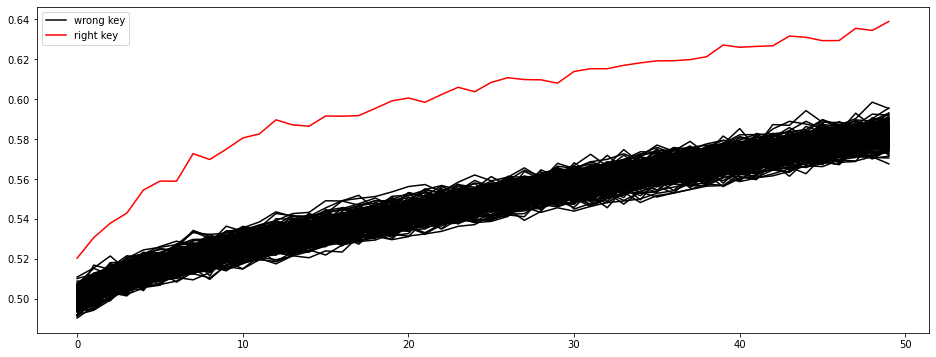

Right candidate:  0xe0


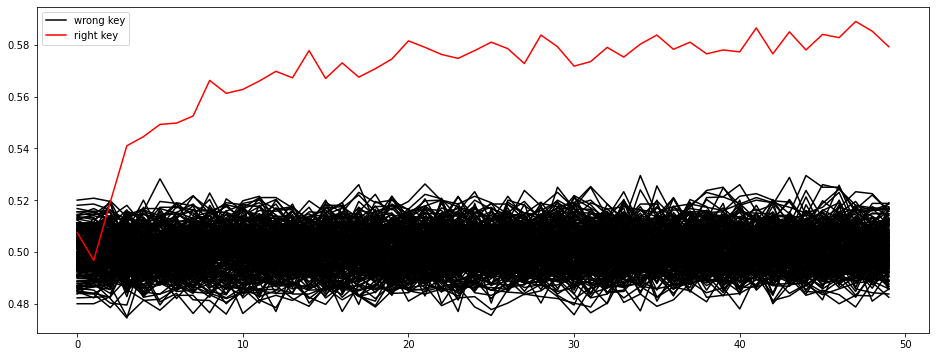

Right candidate:  0xe0


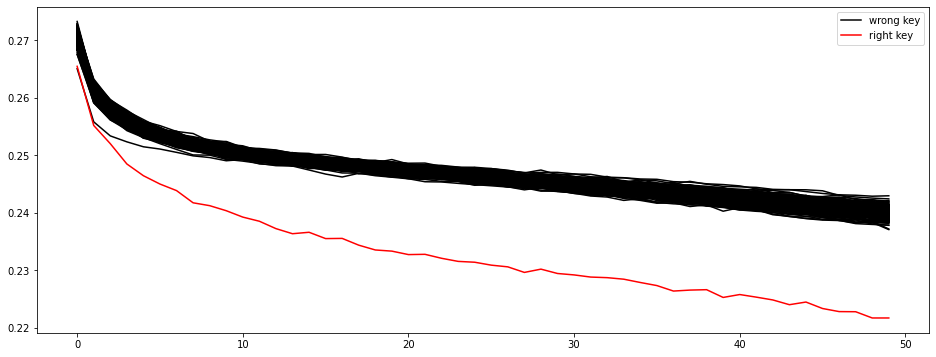

Right candidate:  0xe0


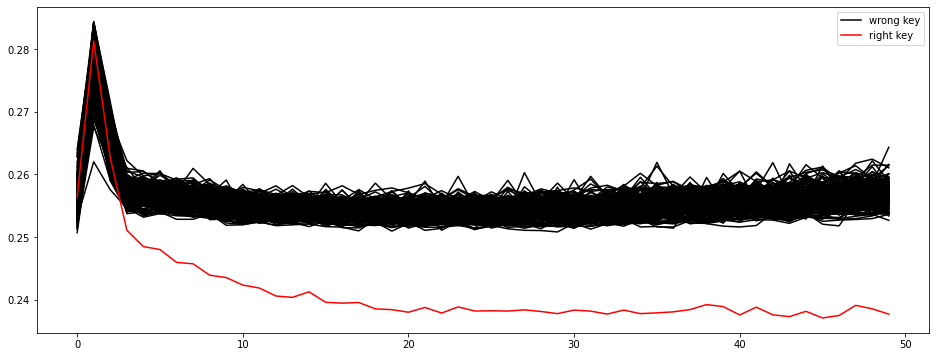

Training ended:  2021-06-29 15:11:07.576499
Elapsed 2257.942850589752


In [26]:
train_num = X_attack.shape[0]

print("============= {} =============".format(train_num))
rand_idx = np.arange(0, train_num) # 반복부분
np.random.shuffle(rand_idx)

T_attack = X_attack_normal[rand_idx]
P_attack = pt_set[rand_idx]

m = build_MLP(T_attack.shape[1], [20], [0])

Init = m.get_weights()

# 학습 시작 시간 측정
print("Training started: ", datetime.datetime.now())
start = time.time()

analysis_MLP(m, Init, T_attack, P_attack, train_num, 256, 'HW', 50, 100, 0xE0)

# 학습 종료 시간 측정 및 소요 시간 계산
elapsed = time.time() - start
print("Training ended: ", datetime.datetime.now())
print("Elapsed", elapsed)

============= 20000 =============


  0%|                                                                                                                               | 0/256 [00:00<?, ?it/s]

Model: "MLSCA"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input (InputLayer)                  [(None, 700)]                   0           
________________________________________________________________________________
sequential_131 (Sequential)         (None, 1)                       16925       
Total params: 16,925
Trainable params: 15,483
Non-trainable params: 1,442
________________________________________________________________________________
Training started:  2021-07-22 15:34:19.789789


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [45:29<00:00, 10.66s/it]


Right candidate:  0xe0


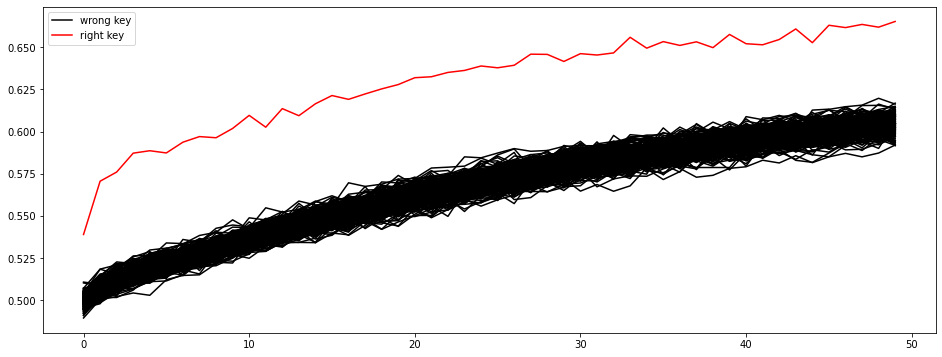

Right candidate:  0xe0


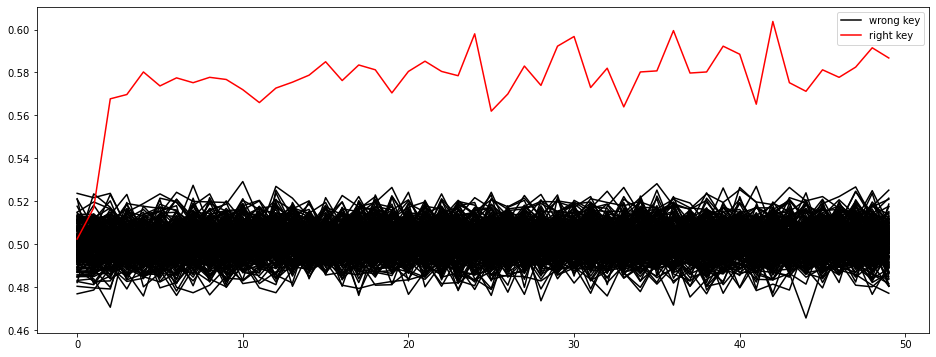

Right candidate:  0xe0


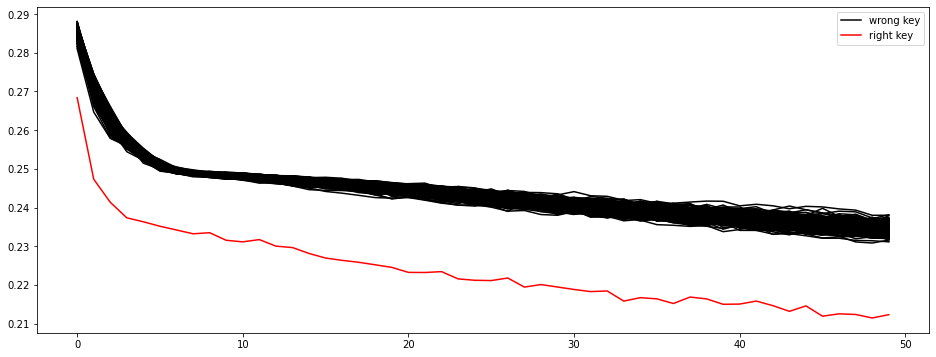

Right candidate:  0xe0


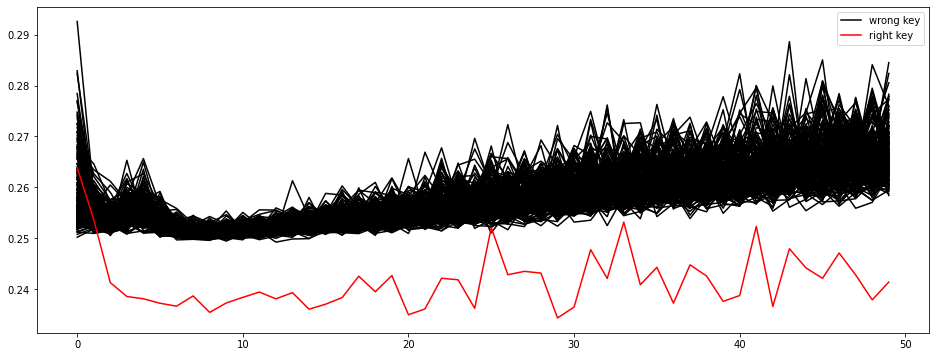

Training ended:  2021-07-22 16:19:51.327331
Elapsed 2731.5375418663025


In [466]:
train_num = X_attack.shape[0]

print("============= {} =============".format(train_num))
rand_idx = np.arange(0, train_num) # 반복부분
np.random.shuffle(rand_idx)

T_attack = X_attack_normal[rand_idx]
P_attack = pt_set[rand_idx]

m = BNN_build_MLP(T_attack.shape[1], [20], [0])

Init = m.get_weights()

# 학습 시작 시간 측정
print("Training started: ", datetime.datetime.now())
start = time.time()

analysis_MLP(m, Init, T_attack, P_attack, train_num, 256, 'HW', 50, 100, 0xE0)

# 학습 종료 시간 측정 및 소요 시간 계산
elapsed = time.time() - start
print("Training ended: ", datetime.datetime.now())
print("Elapsed", elapsed)

In [4]:
HW       = np.array([ 0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4,
                      1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                      1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                      1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                      2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                      3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                      3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                      4, 5, 5, 6, 5, 6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8 ]).astype(np.int8)

In [110]:
a = T_attack[:, 130:170]
b = T_attack[:, 500:540]
print(a.shape, b.shape)

(20000, 40) (20000, 40)


In [111]:
for i in range(40):
    for j in range(40):
        if (i==0 and j==0):
            so_trace = np.array([a[:, i] - b[:, j]])
        tmp = np.array([a[:, i] - b[:, j]])
        so_trace = np.concatenate((so_trace, tmp), axis=0)

print(so_trace.shape)

(1601, 20000)


In [112]:
so_trace = np.transpose(so_trace)

In [113]:
so_trace = np.fabs(so_trace)

In [114]:
print(so_trace)

[[0.         0.         0.02       ... 0.1        0.1        0.        ]
 [0.         0.         0.         ... 0.125      0.10416667 0.        ]
 [0.         0.         0.         ... 0.22916667 0.14583333 0.        ]
 ...
 [0.         0.         0.02061856 ... 0.12371134 0.10309278 0.        ]
 [0.         0.         0.         ... 0.12631579 0.10526316 0.        ]
 [0.         0.         0.         ... 0.18367347 0.14285714 0.        ]]


In [115]:
def correlation(X, Y):
    X = X - np.mean(X, axis=0)
    Y = Y - np.mean(Y, axis=0)
    return np.sum(X * Y, axis=0) / (np.sqrt(np.sum(np.square(X), axis=0)) * np.sqrt(np.sum(np.square(Y), axis=0)))

def SingleByteFOCPA(trace, plain, targetByte):
    KeyCorrs  = []
    MaxPeak   = []
    Ratio     = []

    corrs    = []
    maxCorrs = []
    for GuessKey in tqdm(range(256)):
        IntermediateValue = HW[np.array(Sbox)[(plain[:, targetByte:targetByte+1] ^ GuessKey).astype(int)]]
        corr = np.abs(correlation(trace, IntermediateValue))
        corrs.append(corr)
        maxCorrs.append(np.max(corr))
    key        = np.argmax(maxCorrs)
    RankedCorr = np.sort(maxCorrs)
    
    KeyCorrs.append(corrs)
    MaxPeak.append(maxCorrs)
    Ratio.append(RankedCorr[-1] / RankedCorr[-2]) 
        
    return key, Ratio, KeyCorrs, MaxPeak

  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

Analyzing 3-byte


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [01:48<00:00,  2.35it/s]

Analyzed 3-byte Key : 0x0
Ratio               : [nan]
Max Correlation     : nan


[ MaxPeak Figure ]


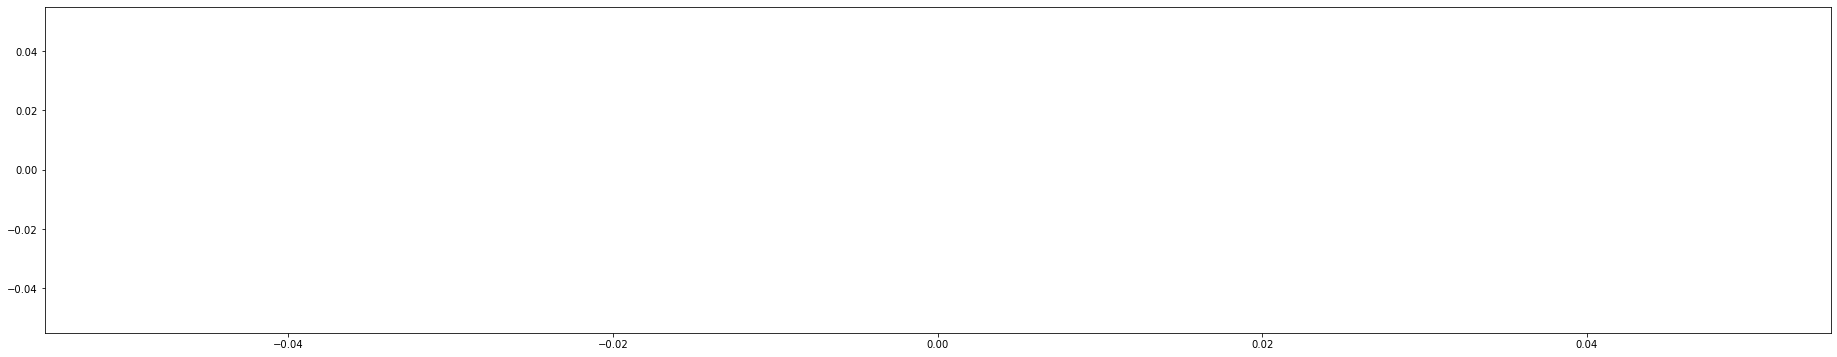



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

In [116]:
AnalyzedKey = []
for targetByte in range(2, 3):
    print("Analyzing {}-byte".format(targetByte + 1))
    key, Ratio, KeyCorrs, MaxPeak = SingleByteFOCPA(so_trace, P_attack, targetByte)
    AnalyzedKey.append(key)
    
    print("Analyzed {}-byte Key : {}".format(targetByte + 1, hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(so_trace[0]))
    p.line(x_range, so_trace[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

In [193]:
def SingleByteFOCPA_bitModel(trace, plain, targetByte, bit):
    KeyCorrs  = []
    MaxPeak   = []
    Ratio     = []

    corrs    = []
    maxCorrs = []
    for GuessKey in tqdm(range(256)):
        hypothesis = np.array(Sbox)[(plain[:, targetByte:targetByte+1] ^ GuessKey).astype(int)]
        IntermediateValue = (hypothesis >> bit) & 1
        corr = np.abs(correlation(trace, IntermediateValue))
        corrs.append(corr)
        maxCorrs.append(np.max(corr))
    key        = np.argmax(maxCorrs)
    RankedCorr = np.sort(maxCorrs)
    
    KeyCorrs.append(corrs)
    MaxPeak.append(maxCorrs)
    Ratio.append(RankedCorr[-1] / RankedCorr[-2]) 
        
    return key, Ratio, KeyCorrs, MaxPeak

  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

Analyzing 3-byte


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [01:48<00:00,  2.35it/s]


Analyzed 3-byte Key : 0xe0
Ratio               : [2.917342143245713]
Max Correlation     : 0.12566119139538942


[ MaxPeak Figure ]


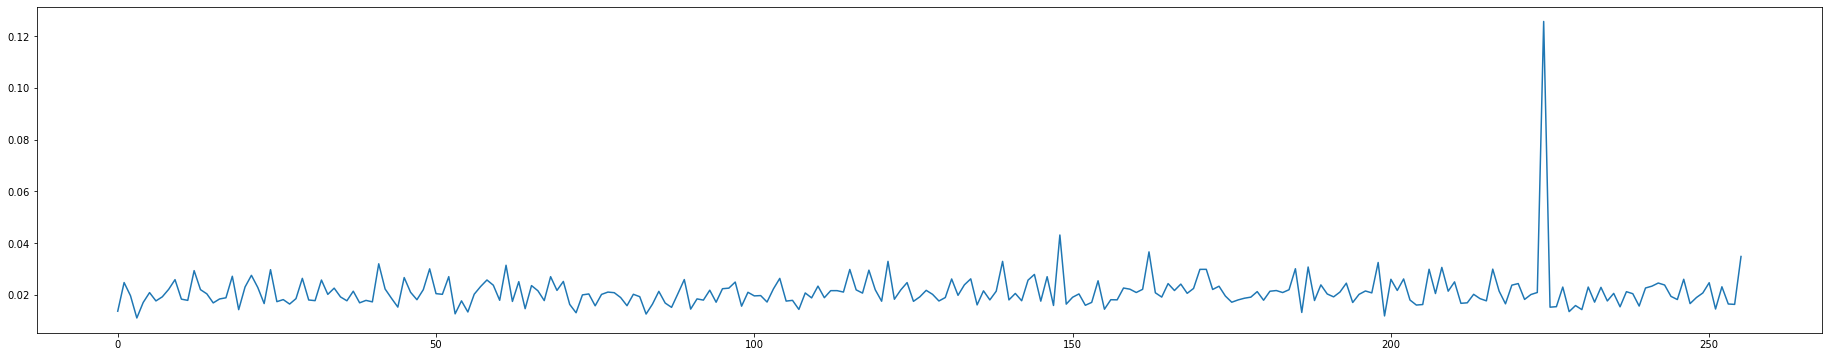



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

In [191]:
AnalyzedKey = []
for targetByte in range(2, 3):
    print("Analyzing {}-byte".format(targetByte + 1))
    key, Ratio, KeyCorrs, MaxPeak = SingleByteFOCPA_bitModel(so_trace, P_attack, targetByte, 0)
    AnalyzedKey.append(key)
    
    print("Analyzed {}-byte Key : {}".format(targetByte + 1, hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(so_trace[0]))
    p.line(x_range, so_trace[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

In [195]:
AnalyzedKey = []
for targetByte in range(2, 3):
    print("Analyzing {}-byte".format(targetByte + 1))
    key, Ratio, KeyCorrs, MaxPeak = SingleByteFOCPA_bitModel(so_trace, P_attack, targetByte, 7)
    AnalyzedKey.append(key)
    
    print("Analyzed {}-byte Key : {}".format(targetByte + 1, hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(so_trace[0]))
    p.line(x_range, so_trace[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

Analyzing 3-byte


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [01:50<00:00,  2.33it/s]


Analyzed 3-byte Key : 0xf
Ratio               : [1.0086525026392328]
Max Correlation     : 0.037425987621502975


[ MaxPeak Figure ]




[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

In [196]:
AnalyzedKey = []
for targetByte in range(2, 3):
    print("Analyzing {}-byte".format(targetByte + 1))
    key, Ratio, KeyCorrs, MaxPeak = SingleByteFOCPA_bitModel(so_trace, P_attack, targetByte, 6)
    AnalyzedKey.append(key)
    
    print("Analyzed {}-byte Key : {}".format(targetByte + 1, hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(so_trace[0]))
    p.line(x_range, so_trace[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

Analyzing 3-byte


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [01:49<00:00,  2.34it/s]


Analyzed 3-byte Key : 0x1c
Ratio               : [1.0416589711933957]
Max Correlation     : 0.036483897448560475


[ MaxPeak Figure ]




[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

Analyzing 3-byte


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [01:50<00:00,  2.31it/s]


Analyzed 3-byte Key : 0x95
Ratio               : [1.0909332483854526]
Max Correlation     : 0.03640065240473506


[ MaxPeak Figure ]


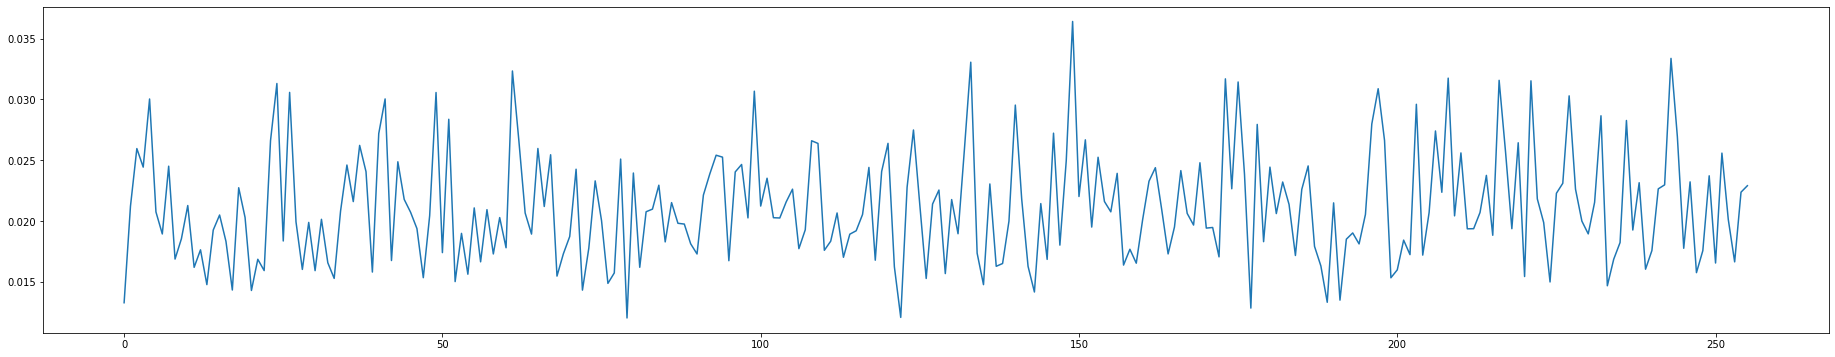



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

In [197]:
AnalyzedKey = []
for targetByte in range(2, 3):
    print("Analyzing {}-byte".format(targetByte + 1))
    key, Ratio, KeyCorrs, MaxPeak = SingleByteFOCPA_bitModel(so_trace, P_attack, targetByte, 5)
    AnalyzedKey.append(key)
    
    print("Analyzed {}-byte Key : {}".format(targetByte + 1, hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(so_trace[0]))
    p.line(x_range, so_trace[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

Analyzing 3-byte


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [01:49<00:00,  2.34it/s]


Analyzed 3-byte Key : 0xe0
Ratio               : [1.5240526088929764]
Max Correlation     : 0.05937370226699185


[ MaxPeak Figure ]


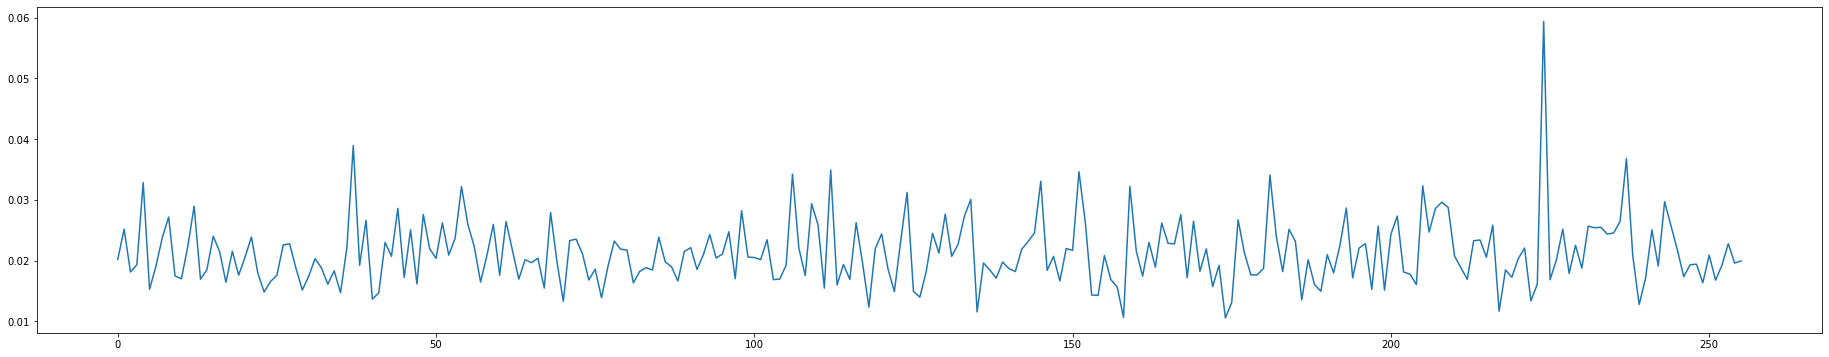



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

In [198]:
AnalyzedKey = []
for targetByte in range(2, 3):
    print("Analyzing {}-byte".format(targetByte + 1))
    key, Ratio, KeyCorrs, MaxPeak = SingleByteFOCPA_bitModel(so_trace, P_attack, targetByte, 4)
    AnalyzedKey.append(key)
    
    print("Analyzed {}-byte Key : {}".format(targetByte + 1, hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(so_trace[0]))
    p.line(x_range, so_trace[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

In [199]:
AnalyzedKey = []
for targetByte in range(2, 3):
    print("Analyzing {}-byte".format(targetByte + 1))
    key, Ratio, KeyCorrs, MaxPeak = SingleByteFOCPA_bitModel(so_trace, P_attack, targetByte, 3)
    AnalyzedKey.append(key)
    
    print("Analyzed {}-byte Key : {}".format(targetByte + 1, hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(so_trace[0]))
    p.line(x_range, so_trace[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

Analyzing 3-byte


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [01:48<00:00,  2.37it/s]


Analyzed 3-byte Key : 0xe0
Ratio               : [1.1942010865401895]
Max Correlation     : 0.041108171215529246


[ MaxPeak Figure ]




[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

Analyzing 3-byte


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [01:48<00:00,  2.35it/s]


Analyzed 3-byte Key : 0xe0
Ratio               : [1.0242374890845223]
Max Correlation     : 0.04044736044203002


[ MaxPeak Figure ]


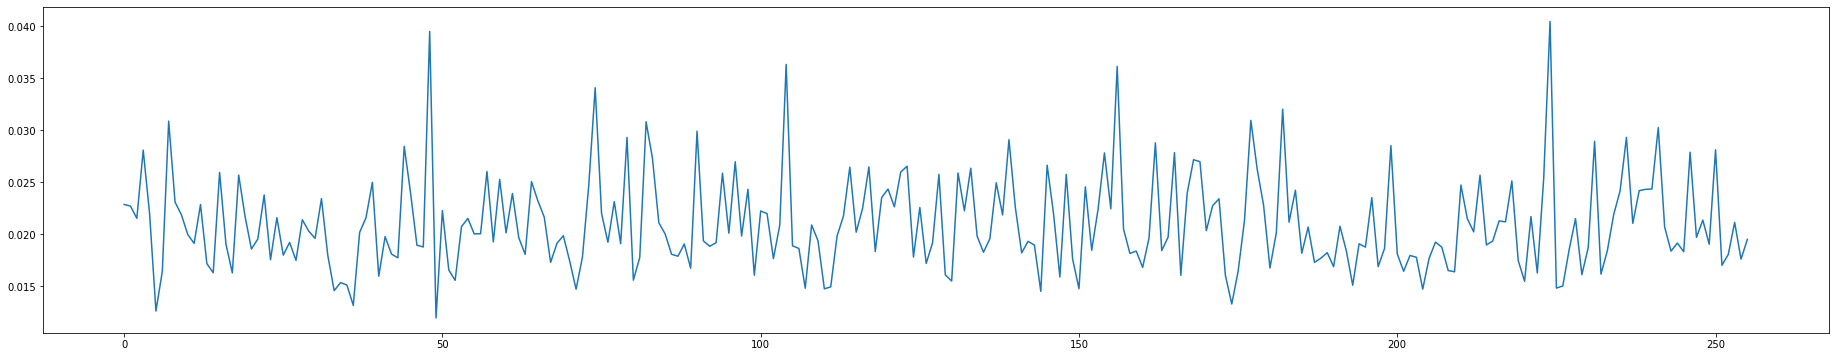



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

In [200]:
AnalyzedKey = []
for targetByte in range(2, 3):
    print("Analyzing {}-byte".format(targetByte + 1))
    key, Ratio, KeyCorrs, MaxPeak = SingleByteFOCPA_bitModel(so_trace, P_attack, targetByte, 2)
    AnalyzedKey.append(key)
    
    print("Analyzed {}-byte Key : {}".format(targetByte + 1, hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(so_trace[0]))
    p.line(x_range, so_trace[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

Analyzing 3-byte


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [01:51<00:00,  2.30it/s]


Analyzed 3-byte Key : 0xe0
Ratio               : [2.0983147647109015]
Max Correlation     : 0.08054624871679628


[ MaxPeak Figure ]


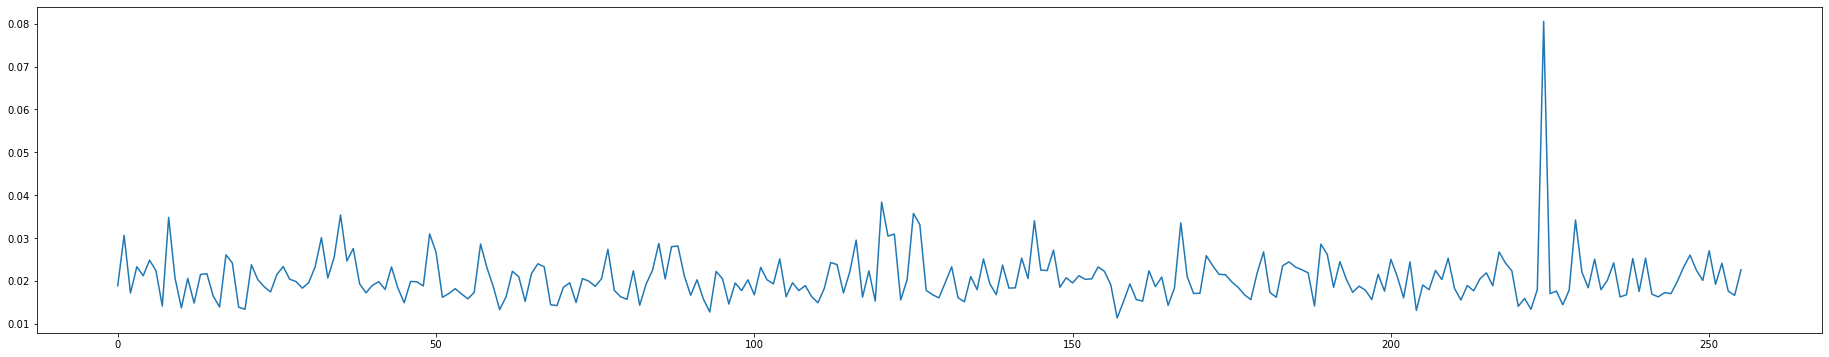



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

In [201]:
AnalyzedKey = []
for targetByte in range(2, 3):
    print("Analyzing {}-byte".format(targetByte + 1))
    key, Ratio, KeyCorrs, MaxPeak = SingleByteFOCPA_bitModel(so_trace, P_attack, targetByte, 1)
    AnalyzedKey.append(key)
    
    print("Analyzed {}-byte Key : {}".format(targetByte + 1, hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(so_trace[0]))
    p.line(x_range, so_trace[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

In [5]:
import random

In [6]:
simul_trace = []
for j in range(20000):
    tmp = []
    for i in range(20):
        tmp.append(random.randint(0, 255))
    simul_trace.append(tmp)
simul_trace = np.array(simul_trace)

In [7]:
simul_pt =[]
for j in range(20000):
    simul_pt.append(random.randint(0, 255))
simul_pt = np.array(simul_pt)

In [8]:
simul_key = []
for j in range(20000):
    simul_key.append(0x82)
simul_key = np.array(simul_key)

In [9]:
simul_pt = simul_pt.reshape(20000, 1)
simul_key = simul_key.reshape(20000, 1)

In [10]:
print(simul_trace.shape)
print(simul_pt.shape)
print(simul_key.shape)

(20000, 20)
(20000, 1)
(20000, 1)


In [11]:
simul_trace[:, 13] = np.array(Sbox)[simul_key[:, 0] ^ simul_pt[:, 0]] ^ simul_trace[:, 1]
simul_trace = HW[simul_trace[:]]
simul_trace = simul_trace + 5
simul_trace[:, 0] = 1
simul_trace[:, 3] = 2
simul_trace[:, 6] = 1
simul_trace[:, 9] = 2
simul_trace[:, 12] = 2
simul_trace[:, 15] = 1
simul_trace[:, 18] = 2

In [12]:
noise = np.random.normal(0, 0.1, size=(20000, 20))

In [13]:
simul_trace = simul_trace + noise

In [14]:
simul_trace.shape

(20000, 20)

In [15]:
print(simul_trace[0])

[ 0.92898133  6.01457416  9.17807908  2.14717457  8.8995205   9.00538907
  0.96819091  9.82412044  7.94948741  2.04801409  9.07507303 11.94821864
  2.03172365 10.92727066  8.94153666  1.01878073  7.87226506 10.03490703
  1.97042153 10.88219944]


In [16]:
tmp = [[[1, 2], [3, 4], [1, 2]]]
tmp = np.array(tmp)
tmp1 = np.transpose(tmp)
print(tmp1.shape)
print(tmp1)
tmp1 = np.reshape(tmp1, (2, 3))
print(tmp.shape)
print(tmp1.shape)
print(tmp)
print(tmp1)

(2, 3, 1)
[[[1]
  [3]
  [1]]

 [[2]
  [4]
  [2]]]
(1, 3, 2)
(2, 3)
[[[1 2]
  [3 4]
  [1 2]]]
[[1 3 1]
 [2 4 2]]


In [17]:
target_byte = 2
All_difference = []

def simul_analysis_MLP(m, Init, traces, pts, tr_num, num_keycandi, result_type, num_epochs, batch_size, right_key):
    right_candi = 0
    right_candida = 0
    accuracies = []
    losses     = []
    
    best_acc = 0
    best_loss = 100
    
    val_right_candi = 0
    val_right_candida = 0
    val_accuracies = []
    val_losses     = []
    
    val_best_acc = 0
    val_best_loss = 100
    
    train_num = int(tr_num * 0.8)
    
    for k in tqdm(range(num_keycandi)):
        m.set_weights(Init)

        hypothesis = np.array(Sbox)[(pts[:] ^ k).astype(int)]
        #target = sum([hypothesis & (1 << i) > 0 for i in range(8)])
        #target = keras.utils.to_categorical(target, 9)
        #target = ((hypothesis >> 7) & 1).astype(float)
        target = (hypothesis & 1).astype(float)
        #target = keras.utils.to_categorical(target, 2)
        #target = np.array([(hypothesis & 1).astype(float), ((hypothesis & 2) >> 1).astype(float),((hypothesis & 4) >> 2).astype(float),((hypothesis & 8) >> 3).astype(float),((hypothesis & 16) >> 4).astype(float),((hypothesis & 32) >> 5).astype(float),((hypothesis & 64) >> 6).astype(float),((hypothesis & 128) >> 7).astype(float)])
        #target = np.transpose(target)
        #target = np.reshape(target, (traces.shape[0], 8))
        
        
        m.fit(x = traces[:train_num], y = target[:train_num], validation_data = (traces[train_num:tr_num], target[train_num:tr_num]), epochs = num_epochs, batch_size = batch_size, verbose = 0)

        accuracies.append(m.history.history['accuracy'])
        if best_acc < m.history.history['accuracy'][num_epochs - 1]:
            best_acc = m.history.history['accuracy'][num_epochs - 1]
            right_candi = k
            
        val_accuracies.append(m.history.history['val_accuracy'])
        if k == 0:
            val_best_acc = m.history.history['val_accuracy'][num_epochs - 1]
            val_right_candi = k
        if val_best_acc < m.history.history['val_accuracy'][num_epochs - 1]:
            val_best_acc = m.history.history['val_accuracy'][num_epochs - 1]
            val_right_candi = k
        
        losses.append(m.history.history['loss'])
        if best_loss > m.history.history['loss'][num_epochs - 1]:
            best_loss = m.history.history['loss'][num_epochs - 1]
            right_candida = k
        
        val_losses.append(m.history.history['val_loss'])
        if k == 0:
            val_best_loss = m.history.history['val_loss'][num_epochs - 1]
            val_right_candida = k
        if val_best_loss > m.history.history['val_loss'][num_epochs - 1]:
            val_best_loss = m.history.history['val_loss'][num_epochs - 1]
            val_right_candida = k
            
    print("Right candidate: ", hex(right_candi))

    plt.figure(figsize = (16, 6))
    for k in range(0, right_candi - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    for k in range(right_candi + 1, num_keycandi - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    plt.plot(accuracies[~right_candi], color = 'black', label = 'wrong key')
    plt.plot(accuracies[right_candi], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    print("Right candidate: ", hex(val_right_candi))

    plt.figure(figsize = (16, 6))
    for k in range(0, val_right_candi - 1):
        plt.plot(val_accuracies[k], color = 'black', label = None)
    for k in range(val_right_candi + 1, num_keycandi - 1):
        plt.plot(val_accuracies[k], color = 'black', label = None)
    plt.plot(val_accuracies[~val_right_candi], color = 'black', label = 'wrong key')
    plt.plot(val_accuracies[val_right_candi], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    print("Right candidate: ", hex(right_candida))
    
    plt.figure(figsize = (16, 6))
    for k in range(0, right_candida - 1):
        plt.plot(losses[k], color = 'black', label = None)
    for k in range(right_candida + 1, num_keycandi - 1):
        plt.plot(losses[k], color = 'black', label = None)
    plt.plot(losses[~right_candida], color = 'black', label = 'wrong key')
    plt.plot(losses[right_candida], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    print("Right candidate: ", hex(val_right_candida))
    
    plt.figure(figsize = (16, 6))
    for k in range(0, val_right_candida - 1):
        plt.plot(val_losses[k], color = 'black', label = None)
    for k in range(val_right_candida + 1, num_keycandi - 1):
        plt.plot(val_losses[k], color = 'black', label = None)
    plt.plot(val_losses[~val_right_candida], color = 'black', label = 'wrong key')
    plt.plot(val_losses[val_right_candida], color = 'red', label = 'right key')
    plt.legend()
    plt.show()

In [18]:
output_notebook()
p = figure(sizing_mode='scale_width', plot_height=200)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(simul_trace[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, simul_trace[i], color=color)
show(p)

Loading BokehJS ...

In [19]:
# 전처리 파형 중 일부사용
simul_trace_normal = np.array(simul_trace[:], dtype='float64')
for i in range(len(simul_trace)):
    simul_trace_normal[i] -= simul_trace_normal[i].mean()
    MIN = min(simul_trace_normal[i])
    MAX = max(simul_trace_normal[i])
    simul_trace_normal[i] = ((simul_trace_normal[i] - MIN)/(MAX - MIN) - 0.5) * 2
    
output_notebook()
p = figure(sizing_mode='scale_width', plot_height=200)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(simul_trace_normal[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, simul_trace_normal[i], color=color)
show(p)

Loading BokehJS ...

In [20]:
def simul_build_MLP(points_len, hidden_nodes = [300, 300, 300], dropout_layers = [0.2, 0.2, 0.2],
              optimizer = keras.optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)):
    model = keras.models.Sequential()
    model.add(layers.BatchNormalization())
    
    # dense 레이어 추가
    model.add(layers.Dense(hidden_nodes[0], kernel_initializer = 'he_normal', input_dim = points_len, name = 'dense_1'))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    
    if dropout_layers[0] != 0:
        model.add(layers.Dropout(dropout_layers[0], name = 'dropout_1'))

    for i, num_units in enumerate(hidden_nodes[1:]):
        model.add(layers.Dense(num_units, kernel_initializer = 'he_normal', name = 'dense_{}'.format(i + 2)))
        model.add(layers.Activation('relu'))
        model.add(layers.BatchNormalization())
        if dropout_layers[i + 1] != 0:
            model.add(layers.Dropout(dropout_layers[i + 1], name = 'dropout_{}'.format(i + 2)))

    model.add(layers.Dense(1, kernel_initializer = 'he_normal', name = 'output'.format(len(hidden_nodes) + 1)))
    model.add(layers.Activation('sigmoid'))
    
    z = layers.Input(shape = (points_len, ), name = 'input')
    sequence = model(z)

    m = keras.models.Model(z, sequence, name = 'MLSCA')
    m.summary(80)
    
    m.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

    return m

  0%|                                                                                                                               | 0/256 [00:00<?, ?it/s]

20000
============= 20000 =============
Model: "MLSCA"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input (InputLayer)                  [(None, 20)]                    0           
________________________________________________________________________________
sequential_112 (Sequential)         (None, 1)                       2681        
Total params: 2,681
Trainable params: 2,441
Non-trainable params: 240
________________________________________________________________________________
Training started:  2021-07-20 13:19:17.674150


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [25:35<00:00,  6.00s/it]


Right candidate:  0x3f


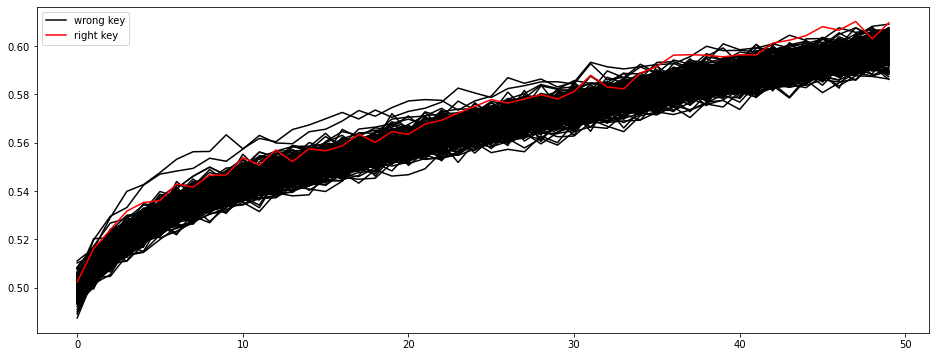

Right candidate:  0x82


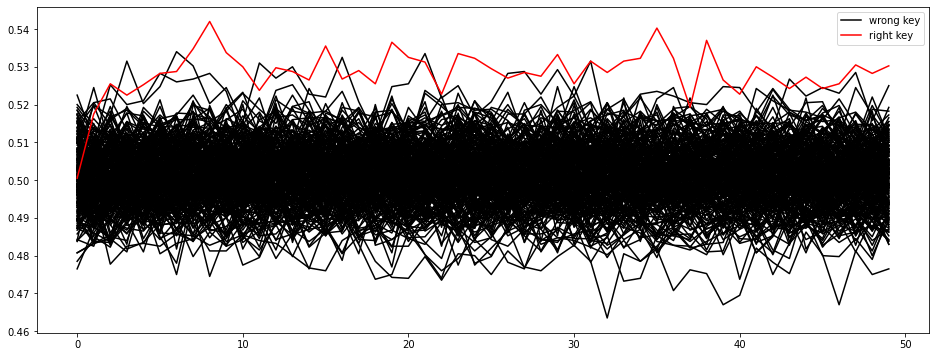

Right candidate:  0x3f


Right candidate:  0xa0


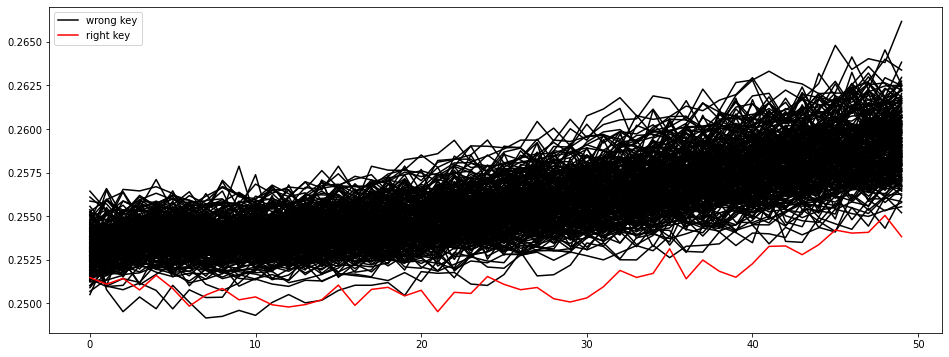

Training ended:  2021-07-20 13:44:55.797030
Elapsed 1538.1218812465668


In [416]:
train_num = simul_trace_normal.shape[0]
print(train_num)

print("============= {} =============".format(train_num))
rand_idx = np.arange(0, train_num) # 반복부분
np.random.shuffle(rand_idx)

simul_T_attack = simul_trace_normal[rand_idx]
simul_P_attack = simul_pt[rand_idx]

m = simul_build_MLP(simul_trace_normal.shape[1], [100], [0])

Init = m.get_weights()

# 학습 시작 시간 측정
print("Training started: ", datetime.datetime.now())
start = time.time()

simul_analysis_MLP(m, Init, simul_T_attack, simul_P_attack, train_num, 256, 'HW', 50, 100, 0xE0)

# 학습 종료 시간 측정 및 소요 시간 계산
elapsed = time.time() - start
print("Training ended: ", datetime.datetime.now())
print("Elapsed", elapsed)

In [21]:
import larq as lq

In [22]:
kwargs = dict(input_quantizer=None,
              kernel_quantizer="ste_tern",
              kernel_constraint="weight_clip",
              use_bias=True)

In [23]:
def BNN_build_MLP(points_len, hidden_nodes = [300, 300, 300], dropout_layers = [0.2, 0.2, 0.2],
              optimizer = keras.optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)):
    model = keras.models.Sequential()
    model.add(layers.BatchNormalization())
    
    # dense 레이어 추가
    model.add(lq.layers.QuantDense(hidden_nodes[0],
                                   **kwargs,
                                   input_dim = points_len, name = 'dense_1'))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    
    if dropout_layers[0] != 0:
        model.add(layers.Dropout(dropout_layers[0], name = 'dropout_1'))

    for i, num_units in enumerate(hidden_nodes[1:]):
        model.add(lq.layers.QuantDense(num_units, **kwargs, name = 'dense_{}'.format(i + 2)))
        model.add(layers.Activation('relu'))
        model.add(layers.BatchNormalization())
        if dropout_layers[i + 1] != 0:
            model.add(layers.Dropout(dropout_layers[i + 1], name = 'dropout_{}'.format(i + 2)))

    model.add(lq.layers.QuantDense(1, **kwargs, name = 'output'.format(len(hidden_nodes) + 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('sigmoid'))
    
    z = layers.Input(shape = (points_len, ), name = 'input')
    sequence = model(z)

    m = keras.models.Model(z, sequence, name = 'MLSCA')
    m.summary(80)
    
    m.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

    return m

20000
============= 20000 =============


  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

Model: "MLSCA"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input (InputLayer)                  [(None, 20)]                    0           
________________________________________________________________________________
sequential (Sequential)             (None, 1)                       1385        
Total params: 1,385
Trainable params: 1,243
Non-trainable params: 142
________________________________________________________________________________
Training started:  2022-08-17 14:59:49.284367


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [24:01<00:00,  5.63s/it]


Right candidate:  0x82


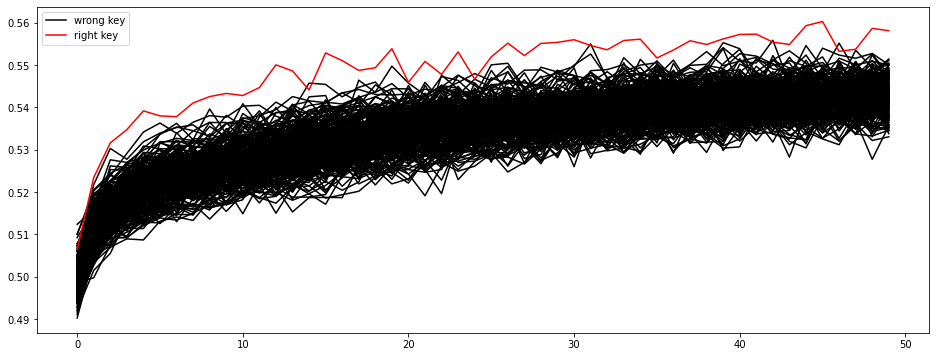

Right candidate:  0x82


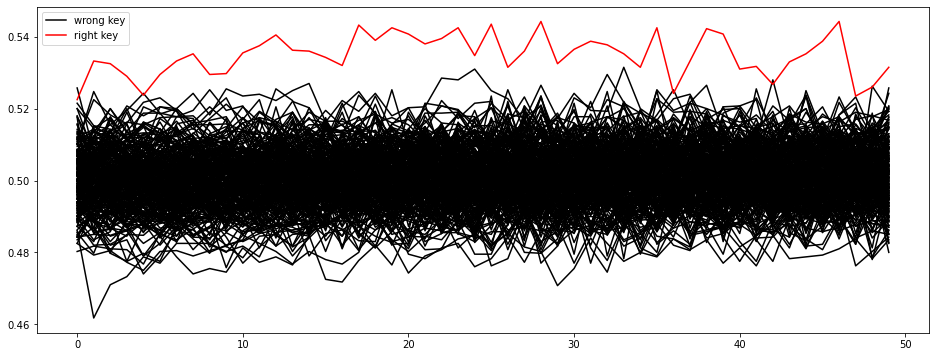

Right candidate:  0x82


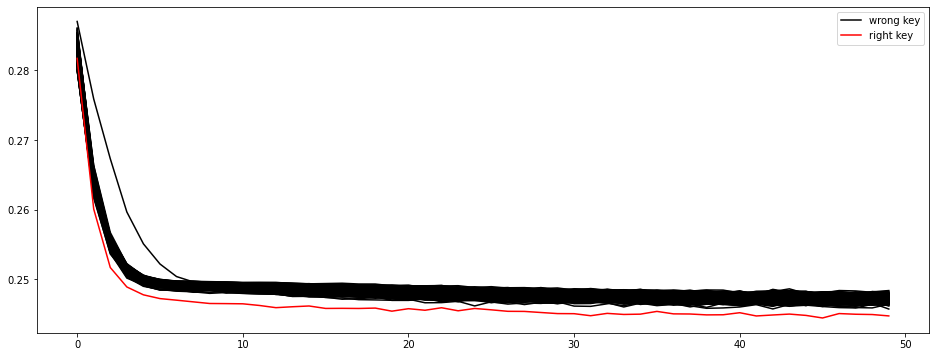

Right candidate:  0x82


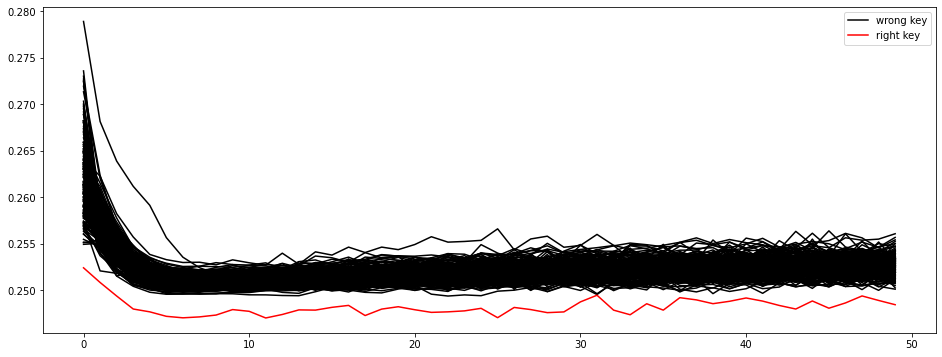

Training ended:  2022-08-17 15:23:53.956415
Elapsed 1444.672048330307


In [24]:
train_num = simul_trace_normal.shape[0]
print(train_num)

print("============= {} =============".format(train_num))
rand_idx = np.arange(0, train_num) # 반복부분
np.random.shuffle(rand_idx)

simul_T_attack = simul_trace_normal[rand_idx]
simul_P_attack = simul_pt[rand_idx]

m = BNN_build_MLP(simul_trace_normal.shape[1], [50], [0])

Init = m.get_weights()

# 학습 시작 시간 측정
print("Training started: ", datetime.datetime.now())
start = time.time()

simul_analysis_MLP(m, Init, simul_T_attack, simul_P_attack, train_num, 256, 'HW', 50, 100, 0xE0)

# 학습 종료 시간 측정 및 소요 시간 계산
elapsed = time.time() - start
print("Training ended: ", datetime.datetime.now())
print("Elapsed", elapsed)

In [ ]:
a = simul_trace[:, 0:10]
b = simul_trace[:, 10:20]

In [262]:
for i in range(10):
    for j in range(10):
        if (i==0 and j==0):
            so_simul_trace = np.array([abs(a[:, i] - b[:, j])])
        else:
            tmp = np.array([abs(a[:, i] - b[:, j])])
            so_simul_trace = np.concatenate((so_simul_trace, tmp), axis=0)
so_simul_trace = np.transpose(so_simul_trace)
#so_simul_trace = np.fabs(so_simul_trace)
print(so_simul_trace.shape)

(20000, 100)


In [263]:
print(so_simul_trace)

[[ 6.94667346  7.04276101  0.87824505 ...  7.0473585   0.08405371
   7.07426975]
 [ 9.08330772  9.12268497  1.01008964 ...  6.83262526  0.02831767
   6.84886729]
 [ 7.87625606  5.97843019  0.84903113 ... 10.24133696  0.0155071
   5.19684173]
 ...
 [ 8.1133131   6.08469772  1.08428952 ...  7.97618038  0.18492893
   6.80455503]
 [11.95800117  8.16639118  0.96922544 ...  8.1204538   0.06354718
   6.8254251 ]
 [ 7.03036653  7.10484702  0.96950379 ...  5.92858997  0.05009536
   8.75519668]]


In [264]:
output_notebook()
p = figure(sizing_mode='scale_width', plot_height=200)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(so_simul_trace[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, so_simul_trace[i], color=color)
show(p)

Loading BokehJS ...

In [265]:
# 전처리 파형 중 일부사용
simul_trace_normal = np.array(so_simul_trace[:], dtype='float64')
for i in range(len(so_simul_trace)):
    simul_trace_normal[i] -= simul_trace_normal[i].mean()
    MIN = min(simul_trace_normal[i])
    MAX = max(simul_trace_normal[i])
    simul_trace_normal[i] = ((simul_trace_normal[i] - MIN)/(MAX - MIN) - 0.5) * 2
    
output_notebook()
p = figure(sizing_mode='scale_width', plot_height=200)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(simul_trace_normal[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, simul_trace_normal[i], color=color)
show(p)

Loading BokehJS ...

In [473]:
def correlation(X, Y):
    X = X - np.mean(X, axis=0)
    Y = Y - np.mean(Y, axis=0)
    return np.sum(X * Y, axis=0) / (np.sqrt(np.sum(np.square(X), axis=0)) * np.sqrt(np.sum(np.square(Y), axis=0)))

def test(trace, plain, bit):
    KeyCorrs  = []
    MaxPeak   = []
    Ratio     = []

    corrs    = []
    maxCorrs = []
    for GuessKey in tqdm(range(1)):
        IntermediateValue = HW[np.array(Sbox)[(plain[:] ^ GuessKey).astype(int)]]
        print(IntermediateValue)
        corr = np.abs(correlation(trace, IntermediateValue))
        corrs.append(corr)
        maxCorrs.append(np.max(corr))
    key        = np.argmax(maxCorrs)
    RankedCorr = np.sort(maxCorrs)
    
    KeyCorrs.append(corrs)
    MaxPeak.append(maxCorrs)
    Ratio.append(RankedCorr[-1] / RankedCorr[-2]) 
        
    return key, Ratio, KeyCorrs, MaxPeak

In [474]:
AnalyzedKey = []

for targetByte in range(2, 3):
    key, Ratio, KeyCorrs, MaxPeak = test(simul_trace_normal, simul_pt, 0)
    AnalyzedKey.append(key)

    print("Analyzed Key        : {}".format(hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(simul_trace_normal[0]))
    p.line(x_range, simul_trace_normal[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.33it/s]

[[6]
 [5]
 [4]
 ...
 [3]
 [4]
 [6]]


IndexError: index -2 is out of bounds for axis 0 with size 1

In [268]:
def test_bit(trace, plain, bit):
    KeyCorrs  = []
    MaxPeak   = []
    Ratio     = []

    corrs    = []
    maxCorrs = []
    for GuessKey in tqdm(range(256)):
        hypothesis = np.array(Sbox)[(plain[:] ^ GuessKey).astype(int)]
        IntermediateValue = (hypothesis >> bit) & 1
        corr = np.abs(correlation(trace, IntermediateValue))
        corrs.append(corr)
        maxCorrs.append(np.max(corr))
    key        = np.argmax(maxCorrs)
    RankedCorr = np.sort(maxCorrs)
    
    KeyCorrs.append(corrs)
    MaxPeak.append(maxCorrs)
    Ratio.append(RankedCorr[-1] / RankedCorr[-2]) 
        
    return key, Ratio, KeyCorrs, MaxPeak

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:07<00:00, 35.74it/s]


bit model           : 0
Analyzed Key        : 0x82
Ratio               : [1.7295016408352746]
Max Correlation     : 0.09153761061243865


[ MaxPeak Figure ]


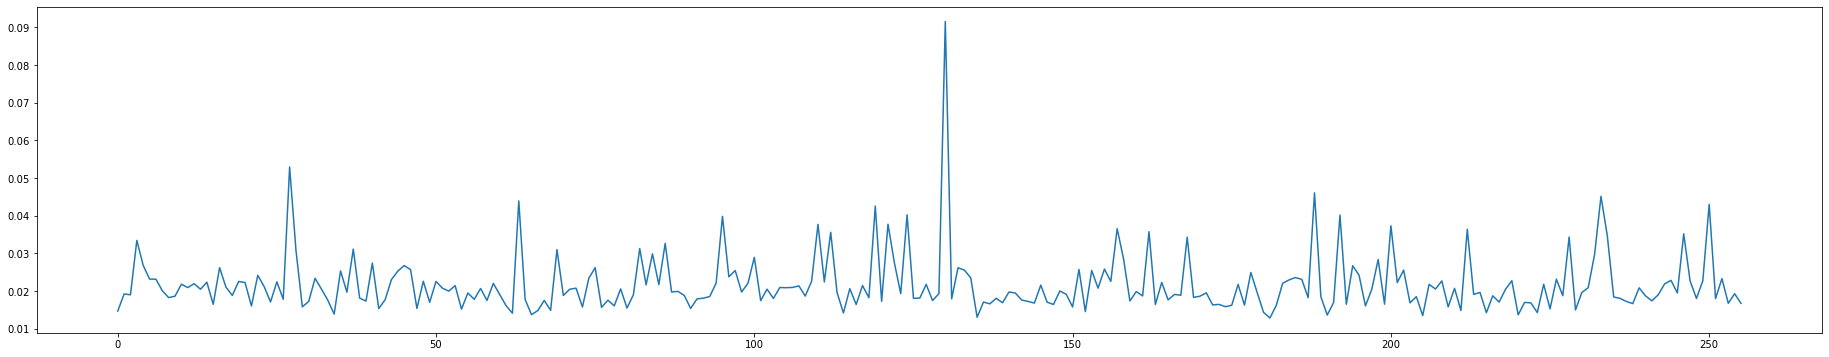



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:07<00:00, 35.46it/s]


bit model           : 1
Analyzed Key        : 0x82
Ratio               : [2.014443145415469]
Max Correlation     : 0.08310505895577683


[ MaxPeak Figure ]


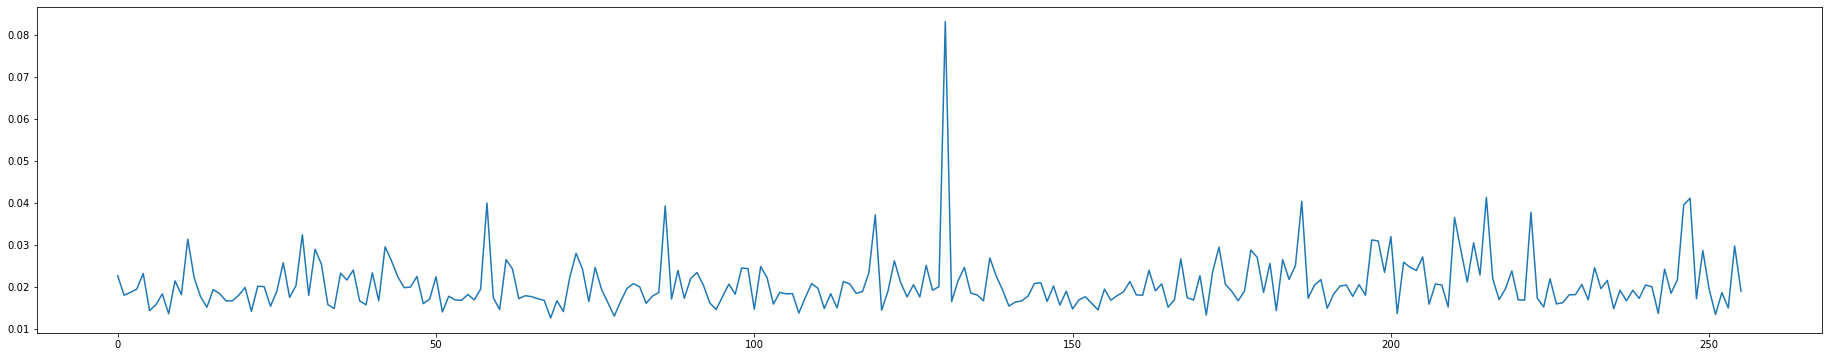



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:07<00:00, 35.22it/s]


bit model           : 2
Analyzed Key        : 0x82
Ratio               : [1.3616806019906265]
Max Correlation     : 0.0838301747550169


[ MaxPeak Figure ]




[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:07<00:00, 36.55it/s]


bit model           : 3
Analyzed Key        : 0x82
Ratio               : [1.313541686033475]
Max Correlation     : 0.07776105953003587


[ MaxPeak Figure ]




[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:07<00:00, 36.37it/s]


bit model           : 4
Analyzed Key        : 0x82
Ratio               : [2.0214398162969585]
Max Correlation     : 0.09133992245997764


[ MaxPeak Figure ]


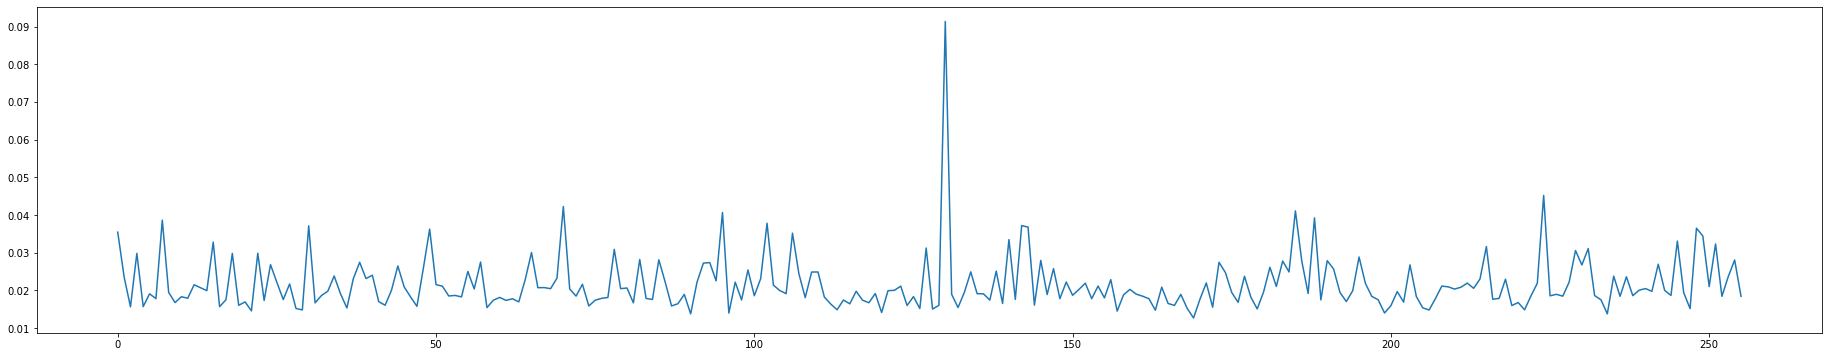



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:07<00:00, 36.18it/s]


bit model           : 5
Analyzed Key        : 0x82
Ratio               : [2.106832416540753]
Max Correlation     : 0.09783655165175976


[ MaxPeak Figure ]




[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:07<00:00, 35.08it/s]


bit model           : 6
Analyzed Key        : 0x82
Ratio               : [1.9792071117354255]
Max Correlation     : 0.0952549513904964


[ MaxPeak Figure ]




[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:07<00:00, 35.99it/s]


bit model           : 7
Analyzed Key        : 0x82
Ratio               : [1.7166391760917852]
Max Correlation     : 0.07985307721962444


[ MaxPeak Figure ]


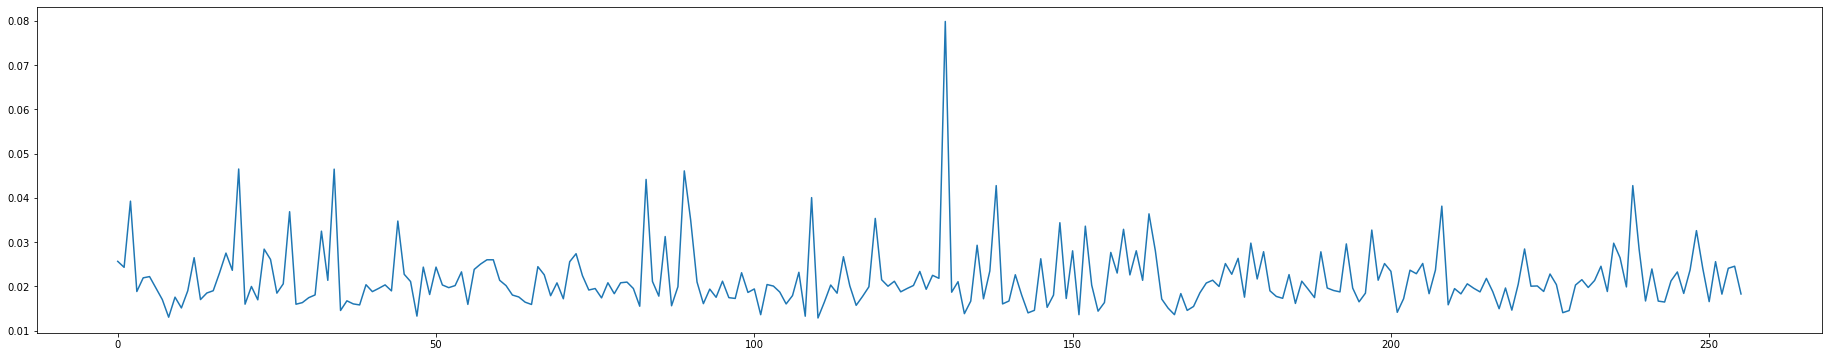



[ Analyzed Key Correlation Peak ]


Loading BokehJS ...

In [269]:
AnalyzedKey = []

for bit in range(0, 8):
    key, Ratio, KeyCorrs, MaxPeak = test_bit(simul_trace_normal, simul_pt, bit)
    AnalyzedKey.append(key)
    
    print("bit model           : {}".format(bit))
    print("Analyzed Key        : {}".format(hex(key)))
    print("Ratio               : {}".format(Ratio))
    print("Max Correlation     : {}".format(MaxPeak[0][key]))
    
    print("\n")
    print("[ MaxPeak Figure ]")
    plt.figure(figsize = (32, 6))
    plt.plot(MaxPeak[0], label = None)
    plt.show()
    
    print("\n")
    print("[ Analyzed Key Correlation Peak ]")
    output_notebook()
    p = figure(sizing_mode='scale_width', plot_height=100)
    t = figure(sizing_mode='scale_width', plot_height=100)
    
    colors = itertools.cycle(palette)
    x_range = range(0, len(simul_trace_normal[0]))
    p.line(x_range, simul_trace_normal[0])
    show(p)
    
    x_range = range(0, len(KeyCorrs[0][key]))
    t.line(x_range, KeyCorrs[0][key])
    show(t)